In [1]:
# Logger
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['pdf.use14corefonts'] = True

# Import local paths
import sys, os
sys.path.append(os.path.abspath('../../..'))
sys.path.append(os.path.abspath('../../../../openai-envs'))

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from lcs.representations.RealValueEncoder import RealValueEncoder
from lcs.agents.racs import RACS, Configuration

# Load OpenAI environments
import gym
import gym_multiplexer

In [2]:
def parse_metrics(metrics):
    lst = [[d['trial'], d['reward'], d['population'], d['reliable']] for d in metrics]

    df = pd.DataFrame(lst, columns=['trial', 'reward', 'population', 'reliable'])
    df = df.set_index('trial')
    df['mode'] = df.index.map(lambda t: "explore" if t % 2 == 0 else "exploit")

    return df

def plot_results(metrics, env, encoder_bits, major_ticker_freq=2000, out_path=None):
    # parse metrics into data frame
    df = parse_metrics(metrics)
    
    # separate explore/exploit data
    explore_df = df[df['mode'] == 'explore']
    exploit_df = df[df['mode'] == 'exploit']
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.suptitle(f"{env.env.spec.id}, ubr encoder bits: {encoder_bits}", fontsize=14)
    
    # plot 1 - average reward
    explore_df['reward'].rolling(window=50).mean().plot(label='explore', ax=ax1)
    exploit_df['reward'].rolling(window=50).mean().plot(label='exploit', ax=ax1)

    ax1.axhline(y=500, color='black', linestyle='--', linewidth=1)
    ax1.axhline(y=1000, color='black', linestyle='--', linewidth=1)

    # ax1.annotate('maximum reward', xy=(500, 950), xycoords='data')
        
    ax1.set_title('Average reward')
    ax1.set_xlabel('Trial')
    ax1.set_ylabel('Average reward')
    ax1.set_ylim(400, 1100)
    
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(major_ticker_freq))
    
    ax1.legend()
    
    # plot 2 - number of classifiers
    df['population'].plot(label='population', ax=ax2)
    df['reliable'].plot(label='reliable', ax=ax2)
    
    ax2.set_title("Classifiers evolution")
    ax2.set_xlabel('Trial')
    ax2.set_ylabel('# Classifiers')
    
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(major_ticker_freq))
    
    ax2.legend()
    
    if out_path:
        f.savefig(out_path, bbox_inches='tight')

# Merging mechanism

In [3]:
# Define function for fetching interesing metrics
def rmpx_metrics(population, environment):
    return {
        'population': len(population),
        'numerosity': sum(cl.num for cl in population),
        'reliable': len([cl for cl in population if cl.is_reliable()])
    }

In [4]:
def benchmark(env, encoder_bits=2, trials=1000):
    
    def build_configuration(do_merging):
        return Configuration(env.observation_space.shape[0], env.action_space.n,
                    encoder=RealValueEncoder(encoder_bits),
                    metrics_trial_frequency=5,
                    user_metrics_collector_fcn=rmpx_metrics,
                    epsilon=1.0,  # no biased exploration
                    do_ga=True,
                    do_merging=do_merging,
                    theta_r=0.9,  # reliablity threshold
                    theta_i=0.2,  # inadequacy threshold
                    theta_ga=100,
                    cover_noise=0,
                    mutation_noise=0.25,
                    chi=1.0,  # cross-over probability
                    mu=0.1)  # mutation probability
    
    # Create configurations
    cfg1 = build_configuration(do_merging=False)
    cfg2 = build_configuration(do_merging=True)
    
    # Build agents
    agent1 = RACS(cfg1)
    agent2 = RACS(cfg2)
    
    # Perform the experiment
    population1, metrics1 = agent1.explore_exploit(env, trials)
    population2, metrics2 = agent2.explore_exploit(env, trials)
    
    return (population1, metrics1), (population2, metrics2)

Define benchmark variables

In [5]:
# Encoder bits
encoder_bits = 3

# Environment
env = gym.make('real-multiplexer-3bit-v0')

# Trials
trials = 50000

Perform benchmark comparison

In [6]:
%%time
res1, res2 = benchmark(env, encoder_bits, trials)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 1000, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 1, 'reward': 0, 'population': 961, 'numerosity': 1925, 'reliable': 57}
INFO:lcs.agents.Agent:{'trial': 10000, 'steps_in_trial': 1, 'reward': 1000, 'population': 652, 'numerosity': 1768, 'reliable': 87}
INFO:lcs.agents.Agent:{'trial': 15000, 'steps_in_trial': 1, 'reward': 0, 'population': 493, 'numerosity': 1872, 'reliable': 87}
INFO:lcs.agents.Agent:{'trial': 20000, 'steps_in_trial': 1, 'reward': 0, 'population': 412, 'numerosity': 1750, 'reliable': 94}
INFO:lcs.agents.Agent:{'trial': 25000, 'steps_in_trial': 1, 'reward': 1000, 'population': 377, 'numerosity': 1881, 'reliable': 89}
INFO:lcs.agents.Agent:{'trial': 30000, 'steps_in_trial': 1, 'reward': 0, 'population': 339, 'numerosity': 1876, 'reliable': 108}
INFO:lcs.agents.Agent:{'trial': 35000, 'steps_in_trial': 1, 'reward': 1000, 'population': 283, 'numerosit

INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 3 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 2 classifiers
INFO:lcs.agents.racs.components.removal:Removing 2 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 2 classifiers
INFO:lcs.agents.racs.components.removal:Removing 2 classifiers
INFO:lcs.agents.racs.components.removal:Removing 2 clas

INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 2 classifiers
INFO:lcs.agents.racs.components.removal:Removing 2 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 2 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 2 clas

INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 3 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 2 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 clas

INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 clas

INFO:lcs.agents.racs.components.removal:Removing 2 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 2 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 clas

INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 clas

INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 2 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 2 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 classifiers
INFO:lcs.agents.racs.components.removal:Removing 1 clas

CPU times: user 35min 36s, sys: 14.6 s, total: 35min 50s
Wall time: 38min 55s


## Performance without merging

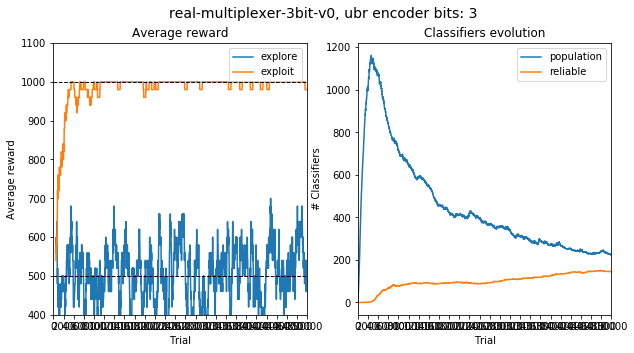

In [7]:
plot_results(res1[1], env, encoder_bits=encoder_bits)

## Performance with merging and removal

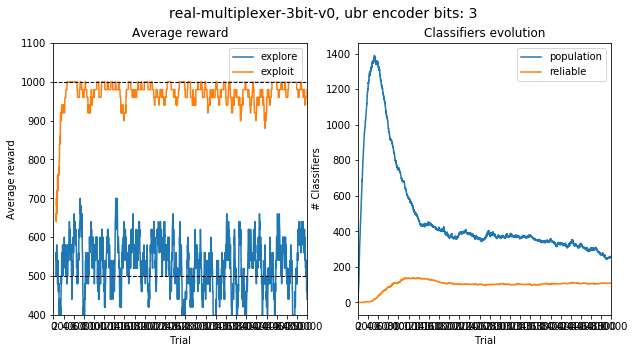

In [8]:
plot_results(res2[1], env, encoder_bits=encoder_bits)